In [1]:
import numpy as np
import pandas as pd
import pickle, os
import spacy
import fasttext
import re

from tqdm.auto import tqdm, trange
from scipy.spatial.distance import cosine

from utils import find_top_n, pro_labeling ,mat_labeling, text_cleaning


from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Preprocessing

In [3]:
# Loading spacy nlp model
spacy_model = spacy.load("en_core_web_sm")

In [4]:
# Getting the titles from file names
title_list = []

for file in os.listdir("Local pdf text files"):
  if file.endswith(".txt"):
    title_list.append(file.split(".")[0])

In [5]:
# Getting the text from local text files
pdf_list = []
    
for file in os.listdir("Local pdf text files"):
  if file.endswith(".txt"):
    with open("Local pdf text files/"+file,"r",encoding="utf8") as f:
        pdf_list.append(f.read())

In [6]:
pdfs = list(map(lambda x: text_cleaning(x,spacy_model), pdf_list))
titles = list(map(lambda x: text_cleaning(x,spacy_model), title_list))

In [7]:
# Concatenating pdfs and titles for tfidf
pdf_title = pdfs.copy() 
for text in titles:
    pdf_title.append(text)

In [8]:
len(pdf_title)

198

In [9]:
# Tfidf for abstracts
vec = TfidfVectorizer(max_df=0.9,min_df=10,stop_words='english',ngram_range=(1, 2))
vec.fit(pdf_title)

# Tfidf for titles
#vec_title = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english',max_features=100,ngram_range=(1, 2))
#vec_abs.fit(titles)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [10]:
#np.array(vec_abs.get_feature_names())

In [11]:
# # np.array(vec_abs.get_feature_names())
# arr1 = X[0].toarray()
# arr2 = X[1].toarray()

In [12]:
# 1-cosine(cer,arr2)

In [13]:
# cer = "A ceramic is a solid material comprising an inorganic compound of metal or metalloid and non-metal with ionic or covalent bonds. Common examples are earthenware, porcelain, and brick."
# y = vec_abs.transform([cer])

In [14]:
# cer = y.toarray()

### Model Installation

In [15]:
# path = "crawl-300d-2M.vec"

# with open('training_data_local_pdf.txt','w',encoding="utf-8") as f:
#     for text in pdf_title:
#         f.write('\n'.join(text.split()))

# train_data = 'training_data_local_pdf.txt'

# ft_model = fasttext.train_unsupervised(input=train_data, pretrainedVectors=path, dim=300)

In [16]:
# Saving the model
#ft_model.save_model("ft_model_local_pdfs.bin")

# Loading the model
ft_model = fasttext.load_model("ft_model_arxiv.bin")

In [17]:
# print(ft_model.similarity(w1='artificial' , w2='intelligence'))

### Labels

In [18]:
# Creating sentences for each document with the strongest tfidf words

tfidf_words_abstract = []

for abstract in tqdm(pdfs):
    tfidf_words_abstract.append(" ".join(find_top_n(abstract,vec,10)))
    
tfidf_words_title = []

for title in tqdm(titles):
    tfidf_words_title.append(" ".join(find_top_n(title,vec,10)))

In [19]:
tfidf_words_abstract[:5]

['base sample printing ceramic characterize mpa hardness new sinter complex',
 'glass size different layer pore temperature material shape increase porosity',
 'ceramic printing present technique component material form main discuss source',
 'fiber reinforce continuous composite print carbon filament use fabrication base',
 'glass need material base manufacturing condition time product research energy']

In [20]:
tfidf_words_title[:5]

['printing ceramic yield fiber fused deposition fused fuse functional fracture formation',
 'printing glass surface print property process machine experimental fracture formation',
 'review ceramic print yield fdm fused fuse functional fracture formation',
 'fiber continuous composite print element form glass electron beam fused deposition fused',
 'glass print fdm fused deposition fused fuse functional fracture formation form']

In [21]:
list(filter(lambda x:len(x.split())==2,list(np.array(vec.get_feature_names()))))

['additive manufacturing',
 'beam melt',
 'deposition model',
 'direct metal',
 'electron beam',
 'fused deposition',
 'laser melt',
 'laser melting',
 'lattice structure',
 'manufacturing technology',
 'mechanical property',
 'melt slm',
 'microstructure mechanical',
 'model fdm',
 'process parameter',
 'rapid prototyping',
 'selective laser',
 'slm process',
 'stainless steel',
 'tensile strength']

In [22]:
pro_1 = ft_model.get_sentence_vector('selective laser melting')
pro_2 = ft_model.get_sentence_vector('direct metal laser sintering')

pro_3 = ft_model.get_sentence_vector('fused deposition modeling')
pro_4 = ft_model.get_sentence_vector('fused filament fabrication')
pro_5 = ft_model.get_sentence_vector('extrusion based additive manufacturing')

metal = ft_model.get_word_vector('metal')
ceramic = ft_model.get_word_vector('ceramic')
polymer = ft_model.get_word_vector('polymer')

# feature_1 = get_embedding('fracture toughness')
# feature_2 = get_embedding('tensile strength')
# feature_3 = get_embedding('yield strength')
# feature_4 = get_embedding('elastic modulus')
# feature_5 = get_embedding('strain fracture break')
# feature_6 = get_embedding('weibull modulus')

In [23]:
def create_df_abs():
    
    d_abs = {'Titles':title_list,
         'Abstracts':pdf_list,
         'Abs_Production':abs_production,
         'Abs_Production_score':abs_production_cos_score,
         'Abs_Material':abs_material,
         'Abs_Material_score':abs_material_cos_score
        }
    
    df = pd.DataFrame(d_abs)
    #df["Production/Material"] = df["Abs_Production"] + " / " + df["Abs_Material"]
    
    return df

In [24]:
def create_df_title():
    
    d_title = {'Titles':title_list,
         'Abstracts':pdf_list,
         'Title_Production':title_production,
         'Title_Production_score':title_production_cos_score,
         'Title_Material':title_material,
         'Title_Material_score':title_material_cos_score
        }
    
    df = pd.DataFrame(d_title)
    #df["Production/Material"] = df["Title_Production"] + " / " + df["Title_Material"]
    
    return df

### Labeling with abstracts and Titles

In [25]:
abs_production , abs_production_cos_score = pro_labeling(tfidf_words_abstract,ft_model,cosine,pro_1,pro_2,pro_3,pro_4,pro_5)
abs_material , abs_material_cos_score = mat_labeling(tfidf_words_abstract,ft_model,cosine,metal,ceramic,polymer)
df_abs = create_df_abs()

title_production , title_production_cos_score = pro_labeling(tfidf_words_title,ft_model,cosine,pro_1,pro_2,pro_3,pro_4,pro_5)
title_material , title_material_cos_score = mat_labeling(tfidf_words_title,ft_model,cosine,metal,ceramic,polymer)
df_title = create_df_title()

In [26]:
df_abs["Abs_Production"].value_counts()

FDM or FFF or EAM    70
SLM or DMLS          29
Name: Abs_Production, dtype: int64

In [27]:
df_title["Title_Production"].value_counts()

FDM or FFF or EAM    54
SLM or DMLS          45
Name: Title_Production, dtype: int64

In [28]:
df_abs["Abs_Material"].value_counts()

Ceramic    58
Polymer    26
Metal      15
Name: Abs_Material, dtype: int64

In [29]:
df_title["Title_Material"].value_counts()

Ceramic    49
Metal      31
Polymer    19
Name: Title_Material, dtype: int64

In [30]:
df_abs.head()

,Titles,Abstracts,Abs_Production,Abs_Production_score,Abs_Material,Abs_Material_score
0,3D gel-printing of zirconia ceramic parts,3D gel-printing (3DGP) is a new printing metho...,FDM or FFF or EAM,0.998097,Ceramic,0.997609
1,3D Printed Glass Surface Finish and Bulk Prope...,It is impossible to print glass directly from ...,SLM or DMLS,0.998682,Ceramic,0.997980
2,3D printing of ceramics A review,Along with extensive research on the three-dim...,FDM or FFF or EAM,0.999350,Ceramic,0.998179
3,3D Printing of Continuous-Fiber Composites by ...,We have developed a method for the three-dimen...,SLM or DMLS,0.999467,Metal,0.998895
4,3D Printing of Transparent Glass,Traditional assembly line manufacturing is spe...,FDM or FFF or EAM,0.999015,Ceramic,0.997971


In [31]:
df_title.head()

,Titles,Abstracts,Title_Production,Title_Production_score,Title_Material,Title_Material_score
0,3D gel-printing of zirconia ceramic parts,3D gel-printing (3DGP) is a new printing metho...,FDM or FFF or EAM,0.999508,Ceramic,0.997689
1,3D Printed Glass Surface Finish and Bulk Prope...,It is impossible to print glass directly from ...,SLM or DMLS,0.999306,Metal,0.998427
2,3D printing of ceramics A review,Along with extensive research on the three-dim...,FDM or FFF or EAM,0.996989,Polymer,0.996782
3,3D Printing of Continuous-Fiber Composites by ...,We have developed a method for the three-dimen...,FDM or FFF or EAM,0.999171,Ceramic,0.997681
4,3D Printing of Transparent Glass,Traditional assembly line manufacturing is spe...,FDM or FFF or EAM,0.997951,Polymer,0.996479


In [32]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [33]:
def visu_pro(doc):
    
    X= []

    for text in doc:
        X.append(ft_model.get_sentence_vector(text))

    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    pca_df = pd.DataFrame(index=title_list,columns=['First Component','Second Component'],data=X_reduced)
    
    if doc == tfidf_words_abstract:
        pca_df["Labels"] = df_abs["Abs_Production"].values
    else :
        pca_df["Labels"] = df_title["Title_Production"].values

    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.scatterplot(x=pca_df['First Component'],y=pca_df['Second Component'],hue=pca_df['Labels'],palette ='Set1')
    
    return pca_df

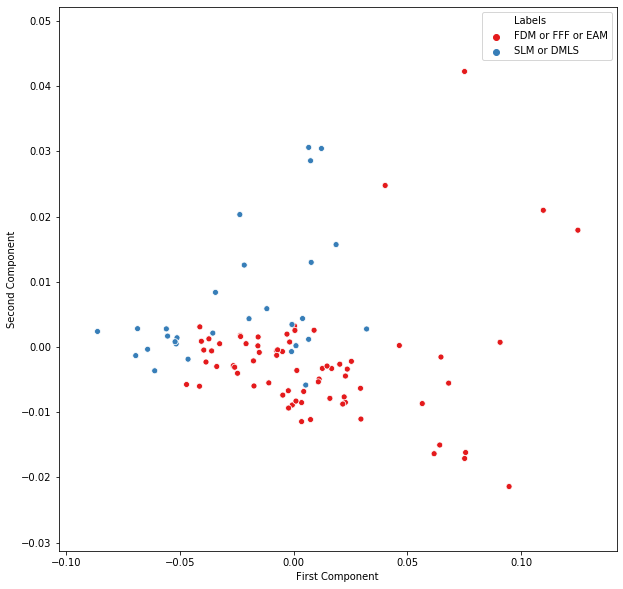

In [34]:
a_pro = visu_pro(tfidf_words_abstract)

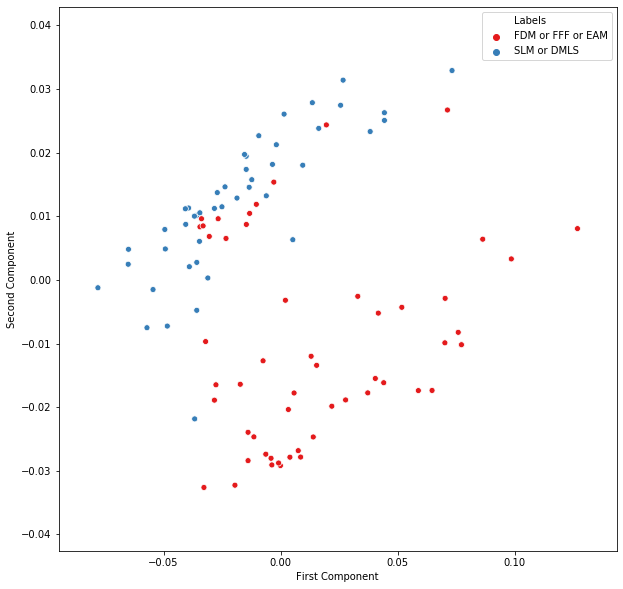

In [35]:
t_pro = visu_pro(tfidf_words_title)

In [36]:
def visu_mat(doc):
    
    X= []

    for text in doc:
        X.append(ft_model.get_sentence_vector(text))

    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    pca_df = pd.DataFrame(index=title_list,columns=['First Component','Second Component'],data=X_reduced)
    
    if doc == tfidf_words_abstract:
        pca_df["Labels"] = df_abs["Abs_Material"].values
    else :
        pca_df["Labels"] = df_title["Title_Material"].values

    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.scatterplot(x=pca_df['First Component'],y=pca_df['Second Component'],hue=pca_df['Labels'],palette ='Set1')
    
    return pca_df

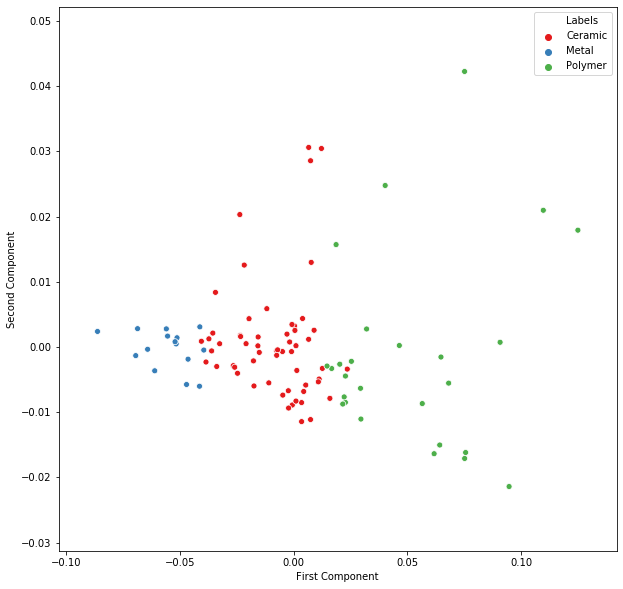

In [37]:
a_mat = visu_mat(tfidf_words_abstract)

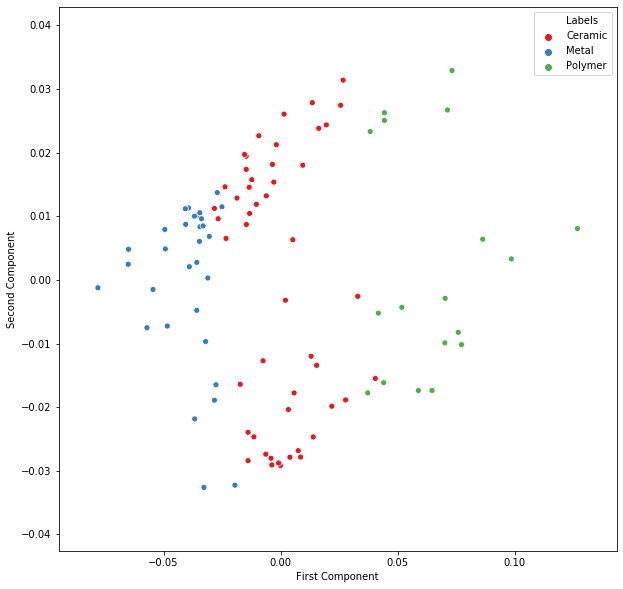

In [38]:
t_mat = visu_mat(tfidf_words_title)

In [39]:
cxvcxvxc

NameError: name 'cxvcxvxc' is not defined

In [ ]:
new_df = pd.DataFrame(dict(Titles=title_list,Abstracts=pdf_list))

new_df["ABS_PRO"] = df_abs["Abs_Production"]
new_df["TITLE_PRO"] = df_title["Title_Production"]

new_df["ABS_MATERIAL"] = df_abs["Abs_Material"]
new_df["TITLE_MATERIAL"] = df_title["Title_Material"]

In [ ]:
new_df.head()

In [ ]:
new_df[new_df.ABS_PRO!=new_df.TITLE_PRO].shape

In [ ]:
new_df[new_df.ABS_MATERIAL!=new_df.TITLE_MATERIAL].shape

In [ ]:
new_df["Titles"][27]

In [ ]:
df_abs.iloc[27]

In [ ]:
df_title.iloc[27]

In [ ]:
####################################################################################

In [ ]:
new_df["Titles"][25]

In [ ]:
df_abs.iloc[25]

In [ ]:
df_title.iloc[25]

In [ ]:
####################################################################################

In [ ]:
new_df["Titles"][46]

In [ ]:
df_abs.iloc[46]

In [ ]:
df_title.iloc[46]

In [ ]:
new_df[(new_df.ABS_MATERIAL!=new_df.TITLE_MATERIAL)&(new_df.ABS_PRO!=new_df.TITLE_PRO)]

In [ ]:
new_df["Titles"][38]

In [ ]:
df_abs.iloc[38]

In [ ]:
df_title.iloc[38]

In [ ]:
####################################################################################

In [ ]:
new_df["Titles"][75]

In [ ]:
df_abs.iloc[75]

In [ ]:
df_title.iloc[75]

In [ ]:
# def vis_docs(abs_n,title_n,doc_type): # Tuple , number, number, list
    
#     # Tfidf for abstracts
#     vec_abs = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english',max_features=100,ngram_range=(1,2))
#     vec_abs.fit(pdfs)

#     # Tfidf for titles
#     vec_title = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english',max_features=100,ngram_range=(1,2))
#     vec_title.fit(titles)
    
#     tfidf_words_abstract = []

#     for abstract in pdfs:
#         tfidf_words_abstract.append(" ".join(find_top_n(abstract,vec_abs,abs_n)))

#     tfidf_words_title = []

#     for title in titles:
#         tfidf_words_title.append(" ".join(find_top_n(title,vec_title,title_n)))
        
#     abs_production , abs_production_cos_score = pro_labeling(tfidf_words_abstract)
#     abs_material , abs_material_cos_score = mat_labeling(tfidf_words_abstract)
#     df_abs = create_df_abs()

#     title_production , title_production_cos_score = pro_labeling(tfidf_words_title)
#     title_material , title_material_cos_score = mat_labeling(tfidf_words_title)
#     df_title = create_df_title()
    
#     X= []

#     for text in doc_type:
#         X.append(ft_model.get_sentence_vector(text))

#     pca = PCA(n_components=2)
#     X_reduced = pca.fit_transform(X)

#     pca_df = pd.DataFrame(index=title_list,columns=['First Component','Second Component'],data=X_reduced)
#     pca_df["Labels"] = df_title["Title_Material"].values
    
#     fig, ax = plt.subplots(figsize=(10,10))
#     ax = sns.scatterplot(x=pca_df['First Component'],y=pca_df['Second Component'],hue=pca_df['Labels'],palette ='Set1')
    
#     return df_abs , df_title 

In [ ]:
# df_abs , df_title = vis_docs(abs_n=20,title_n=10,doc_type=tfidf_words_abstract)

In [ ]:
# df_2 = df_2.drop('que',axis=1)

In [ ]:
# def que(x):
#     if x['Material_title'] == x['Material_abstract']:
#         return True
#     else:
#         return False
    
# df_2['que'] = df_2.apply(que, axis=1)

In [ ]:
# df_2['que'].apply(lambda x:"x['que']" ,if x =="Ceramic",axis=1)

In [ ]:
# sum(df_2['que'])

In [ ]:
# df_2 = df_2[['Titles','Abstracts','Material_abstract','Material_abstract_score','Material_title','Material_title_score','que']]

In [ ]:
# df_2 = df_2.drop(['que'],axis=1)

In [ ]:
# df_2.to_excel("recent_results.xlsx")

In [ ]:
# def r(x):
#     return round(x,2)

# df_2["Material_title_score"] = df_2["Material_title_score"].apply(lambda x:round(x,2))
# df_2["Production_title_score"] = df_2["Production_title_score"].apply(lambda x:round(x,2))

In [ ]:
# temizlemeden bakilabilri aynimi diye
# yuksek olan abs ve titledan birseltirielbilir
# tfidf word sayilariyla oynanabilir

# https://www.datacamp.com/community/tutorials/stemming-lemmatization-python